In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import cv2 # pip install opencv-python
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
RESCALE_SIZE = 224, 224
BATCH_SIZE = 150
Epoch = 10
BASE_PATH = '/content/drive/MyDrive/Жуки/archive/ArTaxOr'
foldername = [ 'Araneae','Coleoptera','Diptera','Hemiptera','Hymenoptera','Lepidoptera','Odonata']
print(f"Using device: {device}")

Using device: cuda:0


In [ ]:
images=[]
labels=[]

for item in foldername:
    dir = os.path.join(BASE_PATH, item)
    for file in os.listdir(dir):
        if file != "annotations":
            images.append(file)
            labels.append(item)
            
data = {'Images':images, 'labels':labels} 
data = pd.DataFrame(data) 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15376 entries, 0 to 15375
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Images  15376 non-null  object
 1   labels  15376 non-null  object
dtypes: object(2)
memory usage: 240.4+ KB


In [ ]:
!pip install pandas

In [ ]:
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.head()

,Images,labels,encoded_labels
0,9b38888c018e.jpg,Araneae,0
1,9618aacd6008.jpg,Araneae,0
2,96773aa08125.jpg,Araneae,0
3,99c3c3b75116.jpg,Araneae,0
4,99db1c36a136.jpg,Araneae,0


In [ ]:
class Arthopod_Dataset(Dataset):
    def __init__(self, img_data,img_path=BASE_PATH,mode="train"):
        self.img_path = img_path
        self.mode = mode
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        if self.mode == "train":
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.CenterCrop(size=RESCALE_SIZE[0] - 90),
                        transforms.RandomRotation(degrees=180),
                        transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
                        # ADDITIONAL AUGMENTATIONS
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        
        else:
            transform = transforms.Compose([
                        transforms.Resize(size=RESCALE_SIZE),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
        img_name = os.path.join(self.img_path,
                                self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = transform(image)
        label_id = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        
        return image, label_id
    


In [ ]:
class Trainer:
    def __init__(self, model, epochs, criterion,
                 optimizer, trainloader,
                 validloader, device, metric,file_name="default.pth",
                 validate=True, scheduler=None,
                 verbose=2):
        self.model = model.to(device)
        self.epochs = epochs
        self.criterion = criterion
        self.optimizer = optimizer
        self.trainloader = trainloader
        self.validloader = validloader
        self.device = device
        self.metric = metric
        self.file_name = file_name
        self.validate = validate
        self.verbose = verbose
        self.scheduler = scheduler
        self.get_probs = nn.Softmax(dim=0)
        self.train_losses = []
        self.valid_losses = []
        self.train_metrics = []
        self.valid_metrics = []
        self.best_model_wts = model.state_dict()
        self.best_metric = 0.0

    def fit(self, epochs=None):
        if epochs is None:
            epochs = self.epochs

        for epoch in range(epochs):
            train_loss, train_metric = self._train(self.trainloader)
            self.train_losses.append(train_loss)
            self.train_metrics.append(train_metric)

            if self.validate:
                val_loss, val_metric = self._validate(self.validloader)
                self.valid_losses.append(val_loss)
                self.valid_metrics.append(val_metric)
                if val_metric > self.best_metric:
                  self.best_metric = val_metric
                  self.best_model_wts = model.state_dict()
                  torch.save(model.state_dict(), os.path.join("/content/drive/MyDrive/Жуки/", self.file_name))
                if self.scheduler is not None:
                    self.scheduler.step(val_loss)
            
            else:
                val_loss = "NO"

            if self.verbose > 0:
                print()
                print(f"Epoch {epoch+1} out of {epochs}: Train loss = {train_loss}, validation loss = {val_loss} \n\
                                         Train metric = {train_metric}, validation metric = {val_metric}")
                print()
        
        return self

    def _train(self, loader):
        self.model.train()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            out = self.model(inputs)
            loss = self.criterion(out, targets)
            epoch_loss += loss.item()
            self.optimizer.zero_grad()
            loss.backward()

            if self.verbose > 1:
                print(f"\rTraining: batch {i+1} out of {len(loader)}", end="")

            self.optimizer.step()

            out = self.get_probs(out)
            _, preds = torch.max(out.data, 1)
            epoch_preds += list(preds.cpu())
            epoch_targets += list(targets.detach().cpu())

            self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric

    def _validate(self, loader):
        self.model.eval()
        epoch_loss = 0
        epoch_preds = []
        epoch_targets = []
        with torch.no_grad():
            for i, (inputs, targets) in enumerate(loader):
                inputs, targets = inputs.to(self.device), targets.to(self.device)              
                out = self.model(inputs)
                loss = self.criterion(out, targets)

                if self.verbose > 1:
                    print(f"\rValidation: batch {i+1} out of {len(loader)}", end="")

                epoch_loss += loss.item()
                out = self.get_probs(out)
                _, preds = torch.max(out.data, 1)
                epoch_preds += list(preds.cpu())
                epoch_targets += list(targets.detach().cpu())

                self._clear_vram(inputs, targets, out)

        epoch_loss = epoch_loss/len(loader)
        epoch_metric = self.metric(epoch_targets, epoch_preds)
        print("\n", end="")

        return epoch_loss, epoch_metric
    
    def _clear_vram(self, inputs, labels, outputs):
        inputs = inputs.to("cpu")
        labels = labels.to("cpu")
        outputs = outputs.to("cpu")
        del inputs, labels, outputs
        torch.cuda.empty_cache()

In [ ]:
def predict(model, loader):
    model.eval()
    predictions = []
    targ = []
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(loader):
            inputs, targets = inputs.to(device), targets.to(device)              
            out = model(inputs)
            out = nn.functional.softmax(out, dim=-1)
            _, preds = torch.max(out.data, 1)
            predictions += list(preds)
            targ += list(targets)
    
    return predictions, targ

def calculate_metric(model, loader, metric=None):
    if metric is None:
        metric = accuracy_score
    
    preds, targets = predict(model, loader)
    preds = [i.item() for i in preds]
    targets = [i.item() for i in targets]

    return metric(targets, preds)

In [ ]:
train_files, val_files = train_test_split(data, test_size=0.25, \
                                          stratify=data.encoded_labels)


In [ ]:
train_files = pd.DataFrame(np.array(train_files),columns=["Images","labels","encoded_labels"])
val_files = pd.DataFrame(np.array(val_files),columns=["Images","labels","encoded_labels"])

In [ ]:
trainset = Arthopod_Dataset(train_files)
valset = Arthopod_Dataset(val_files, mode="val")

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


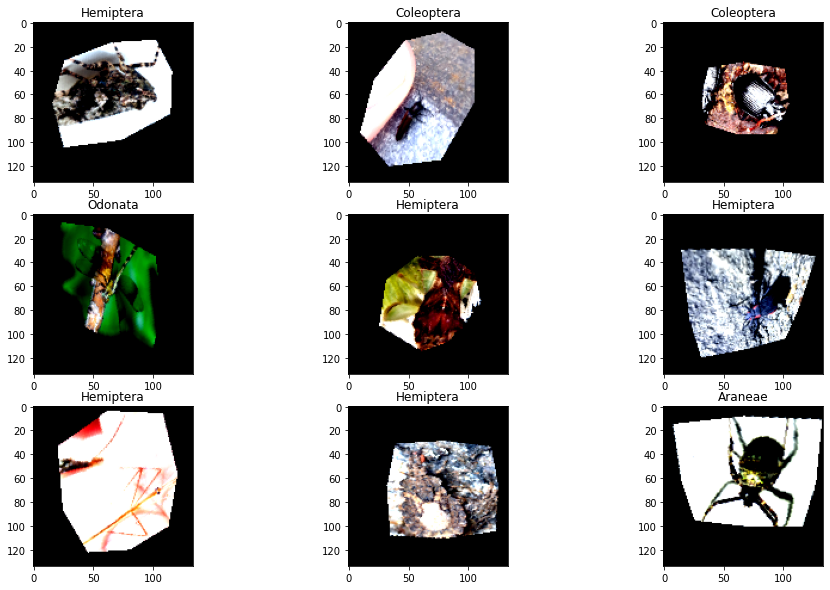

In [ ]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
arthopod_types = {0:"Araneae",1:"Coleoptera",2:"Diptera",
                  3:"Hemiptera",4:"Hymenoptera",5:"Lepidoptera",6:"Odonata"}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 3, figsize=(16, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [ ]:
model = torchvision.models.vgg19_bn(pretrained=True)

In [ ]:
num_features = 4096
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(num_features,7)
#model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

In [ ]:
!nvidia-smi

Thu May  5 20:19:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    57W / 149W |   1581MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
trainer = Trainer(model, 10, criterion, optimizer, trainloader, valloader, device, accuracy_score,file_name = "VGG19_best_tune.pth",scheduler=scheduler)
trainer.fit()

Training: batch 77 out of 77
Validation: batch 26 out of 26

Epoch 1 out of 10: Train loss = 1.7381701732610728, validation loss = 1.5744873606241667 
                                         Train metric = 0.3237946583420049, validation metric = 0.4929760665972945

Training: batch 7 out of 77

KeyboardInterrupt: ignored

In [ ]:
trainset = Arthopod_Dataset(train_files)
valset = Arthopod_Dataset(val_files, mode="val")

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model2 = torchvision.models.resnet50(pretrained=True)

In [ ]:
num_features = 2048
for param in model2.parameters():
    param.requires_grad = False
model2.fc = nn.Linear(in_features=2048, out_features=7, bias=True)
#model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model2 = model2.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, patience=3, factor=0.5)

In [ ]:
trainer = Trainer(model2, 10, criterion, optimizer, trainloader, valloader, device, accuracy_score,file_name = "resnet50_best_tune.pth",scheduler=scheduler)
trainer.fit()

Training: batch 15 out of 77

In [ ]:
def predict_one_sample(model, inputs, device=device):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()

    return probs


def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp.reshape(*RESCALE_SIZE), cmap="gray")
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)


def get_predicts(model, test_loader):
    with torch.no_grad():
        logits = []
        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()

    return probs